**Execute the below cell directly – might take ~1min to import everything!**

In [1]:
%%time
import pickle, uproot
import pandas as pd
import numpy as np
import awkward as ak

import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import mplhep as hep
mpl.rcParams.update({'font.size': 20})

import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l1

from sklearn.metrics import roc_curve
hep.style.use("CMS")

/cvmfs/cms.cern.ch/el8_amd64_gcc11/external/py3-numpy/1.24.3-65e90ecb70381ce16713acda444b17a0/lib/python3.9/site-packages/numpy/core/getlimits.py:518: UserWarning: The value of the smallest subnormal for <class 'numpy.float32'> type is zero.
  setattr(self, word, getattr(machar, word).flat[0])
/cvmfs/cms.cern.ch/el8_amd64_gcc11/external/py3-numpy/1.24.3-65e90ecb70381ce16713acda444b17a0/lib/python3.9/site-packages/numpy/core/getlimits.py:89: UserWarning: The value of the smallest subnormal for <class 'numpy.float32'> type is zero.
  return self._float_to_str(self.smallest_subnormal)
/cvmfs/cms.cern.ch/el8_amd64_gcc11/external/py3-numpy/1.24.3-65e90ecb70381ce16713acda444b17a0/lib/python3.9/site-packages/numpy/core/getlimits.py:518: UserWarning: The value of the smallest subnormal for <class 'numpy.float64'> type is zero.
  setattr(self, word, getattr(machar, word).flat[0])
/cvmfs/cms.cern.ch/el8_amd64_gcc11/external/py3-numpy/1.24.3-65e90ecb70381ce16713acda444b17a0/lib/python3.9/site-pac

CPU times: user 3.21 s, sys: 780 ms, total: 3.99 s
Wall time: 5.63 s


In [ ]:
# don't run this cell
%pip install xxhash

In [2]:
fname = "/eos/user/e/etsai/workspace/preprocessing-scripts/jetTuple.root"
f = uproot.open(fname)

In [3]:
branches = ["jet_genmatch_pt", "jet_muflav", "jet_tauflav", "jet_elflav", "jet_genmatch_hflav",
            "jet_genmatch_pflav", "jet_bjetscore", "jet_pt", "jet_eta"]
data = f["jetntuple;1"]["tree;6"].arrays(filter_name=branches, how="zip")

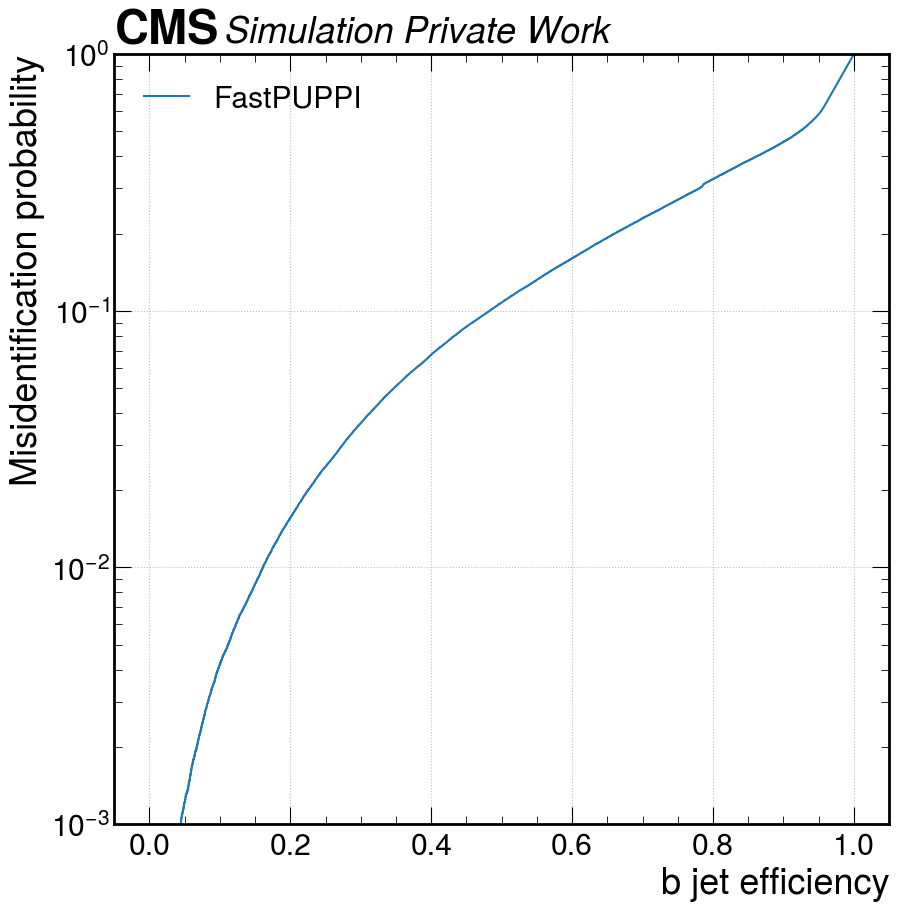

In [26]:
jetmask = (data.jet_genmatch_pt>-1) & (data.jet_pt>20) & (abs(data.jet_eta)<2.4)
jetmask = jetmask & (data.jet_muflav==0)
jetmask = jetmask & (data.jet_tauflav==0)
jetmask = jetmask & (data.jet_elflav==0)
bmask = jetmask & (data.jet_genmatch_hflav==5)
udsgmask = jetmask & ((abs(data.jet_genmatch_pflav)<4) & (abs(data.jet_genmatch_pflav)>=0) & (abs(data.jet_genmatch_hflav)==0)) | ((abs(data.jet_genmatch_pflav)==21) & (abs(data.jet_genmatch_hflav)==0))
bjets = data.jet_bjetscore[bmask]
udsgjets = data.jet_bjetscore[udsgmask]
bscore = ak.concatenate([bjets, udsgjets])
whichjet = np.concatenate([np.ones(len(bjets)), np.zeros(len(udsgjets))])
fpr0, tpr0, thr = roc_curve(whichjet, bscore, drop_intermediate=False)

plt.figure()
plt.plot(tpr0, fpr0, label="FastPUPPI")
plt.xlabel("b jet efficiency")
plt.ylabel("Misidentification probability")
plt.yscale("log")
plt.ylim(1e-3, 1)
plt.grid()
plt.legend()
hep.cms.label("Private Work", data=False, rlabel="")
plt.savefig("part1_outputs/ROC_FastPUPPI.pdf")
plt.savefig("part1_outputs/ROC_FastPUPPI.png")

In [6]:
fname_part1 = "/eos/user/e/etsai/workspace/preprocessing-scripts/parTV1.root"
fname_part2 = "/eos/user/e/etsai/workspace/preprocessing-scripts/parTV2.root"
fname_part3 = "/eos/user/e/etsai/workspace/preprocessing-scripts/parTV3.root"
fname_part4 = "/eos/user/e/etsai/workspace/preprocessing-scripts/mergedV4.root"

fpart1 = uproot.open(fname_part1)
fpart2 = uproot.open(fname_part2)
fpart3 = uproot.open(fname_part3)
fpart4 = uproot.open(fname_part4)

In [16]:
branches1 = ["label_b", "label_uds", "label_g", "score_label_b", "score_label_uds", "score_label_g",
             "jet_pt", "jet_eta"]
data1 = fpart1["Events;1"].arrays(filter_name=branches1, how="zip")

branches2 = ["label_b", "label_uds", "label_g", "score_label_b", "score_label_uds", "score_label_g",
             "jet_pt", "jet_eta"]
data2 = fpart2["Events;1"].arrays(filter_name=branches2, how="zip")

branches3 = ["label_b", "label_udsc", "label_g", "score_label_b", "score_label_udsc", "score_label_g",
             "jet_pt", "jet_eta"]
data3 = fpart3["Events;1"].arrays(filter_name=branches3, how="zip")

branches4 = ["label_b", "label_udsg", "score_label_b", "score_label_udsg", "jet_pt", "jet_eta"]
data4 = fpart4["Events;1"].arrays(filter_name=branches4, how="zip")

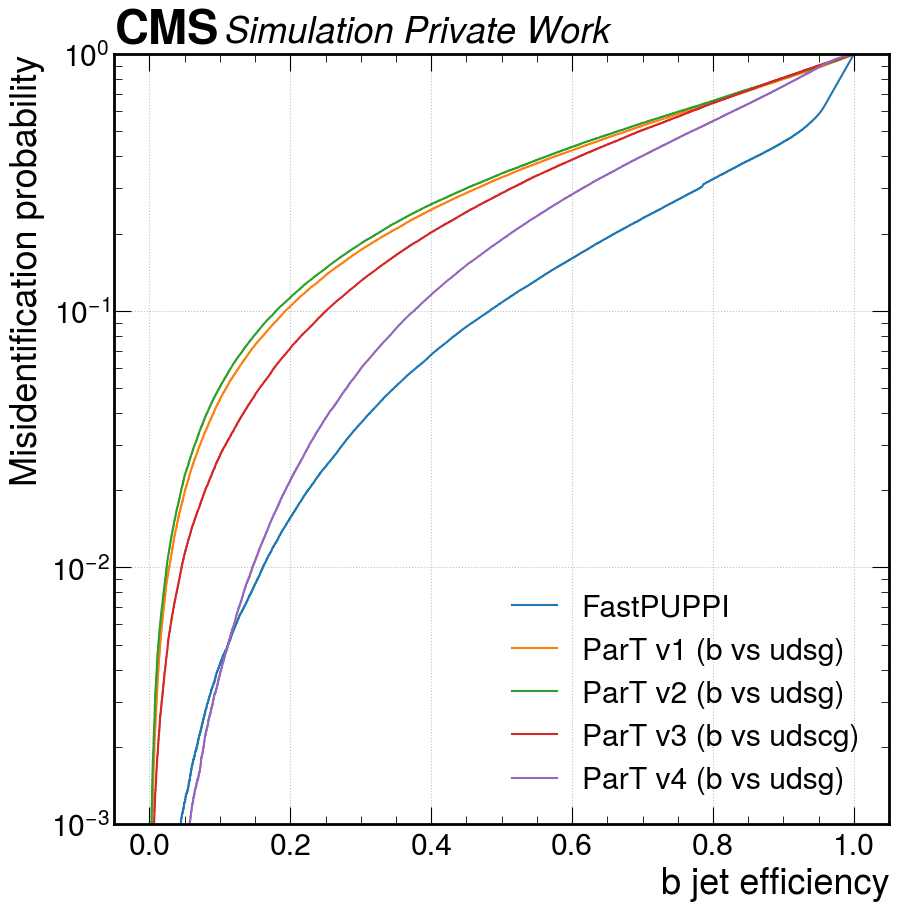

In [27]:
bmask = (data1.label_b==1)
udsgmask = (data1.label_uds==1) | (data1.label_g==1)
btag = data1.score_label_b / (data1.score_label_b + data1.score_label_uds + data1.score_label_g)
bjets = btag[bmask]
udsgjets = btag[udsgmask]
bscore = ak.concatenate([bjets, udsgjets])
whichjet = np.concatenate([np.ones(len(bjets)), np.zeros(len(udsgjets))])
fpr1, tpr1, thr1 = roc_curve(whichjet, bscore, drop_intermediate=False)

bmask = (data2.label_b==1)
udsgmask = (data2.label_uds==1) | (data2.label_g==1)
btag = data2.score_label_b / (data2.score_label_b + data2.score_label_uds + data2.score_label_g)
bjets = btag[bmask]
udsgjets = btag[udsgmask]
bscore = ak.concatenate([bjets, udsgjets])
whichjet = np.concatenate([np.ones(len(bjets)), np.zeros(len(udsgjets))])
fpr2, tpr2, thr2 = roc_curve(whichjet, bscore, drop_intermediate=False)

bmask = (data3.label_b==1)
udscgmask = (data3.label_udsc==1) | (data3.label_g==1)
btag = data3.score_label_b / (data3.score_label_b + data3.score_label_udsc + data3.score_label_g)
bjets = btag[bmask]
udscgjets = btag[udscgmask]
bscore = ak.concatenate([bjets, udscgjets])
whichjet = np.concatenate([np.ones(len(bjets)), np.zeros(len(udscgjets))])
fpr3, tpr3, thr3 = roc_curve(whichjet, bscore, drop_intermediate=False)

bmask = (data4.label_b==1)
udsgmask = (data4.label_udsg==1)
btag = data4.score_label_b / (data4.score_label_b + data4.score_label_udsg)
bjets = btag[bmask]
udsgjets = btag[udsgmask]
bscore = ak.concatenate([bjets, udsgjets])
whichjet = np.concatenate([np.ones(len(bjets)), np.zeros(len(udsgjets))])
fpr4, tpr4, thr4 = roc_curve(whichjet, bscore, drop_intermediate=False)

plt.figure()
plt.plot(tpr0, fpr0, label="FastPUPPI")
plt.plot(tpr1, fpr1, label="ParT v1 (b vs udsg)")
plt.plot(tpr2, fpr2, label="ParT v2 (b vs udsg)")
plt.plot(tpr3, fpr3, label="ParT v3 (b vs udscg)")
plt.plot(tpr4, fpr4, label="ParT v4 (b vs udsg)")
plt.legend()
plt.xlabel("b jet efficiency")
plt.ylabel("Misidentification probability")
plt.yscale("log")
plt.ylim(1e-3, 1)
plt.grid()
hep.cms.label("Private Work", data=False, rlabel="")
plt.savefig("part1_outputs/ROC_All.pdf")
plt.savefig("part1_outputs/ROC_All.png")

In [ ]:
pt_ranges = [[20, 50], [50, 100], [100, 250], [250, 10000]]
for pt_range in pt_ranges:

    # FastPUPPI
    jetmask = (data.jet_genmatch_pt>-1) & (data.jet_muflav==0) & (data.jet_tauflav==0) & (data.jet_elflav==0)
    jetmask = jetmask & (data.jet_pt>pt_range[0]) & (data.jet_pt<pt_range[1]) & (abs(data.jet_eta)<2.4)
    bmask = jetmask & (data.jet_genmatch_hflav==5)
    udsgmask = jetmask & ((abs(data.jet_genmatch_pflav)<4) & (abs(data.jet_genmatch_pflav)>=0) & (abs(data.jet_genmatch_hflav)==0)) | ((abs(data.jet_genmatch_pflav)==21) & (abs(data.jet_genmatch_hflav)==0))
    bjets = data.jet_bjetscore[bmask]
    udsgjets = data.jet_bjetscore[udsgmask]
    bscore = ak.concatenate([bjets, udsgjets])
    whichjet = np.concatenate([np.ones(len(bjets)), np.zeros(len(udsgjets))])
    fpr0, tpr0, thr = roc_curve(whichjet, bscore, drop_intermediate=False)

    # Particle Transformer V1
    jetmask = (data1.jet_pt>pt_range[0]) & (data1.jet_pt<pt_range[1]) & (abs(data1.jet_eta)<2.4)
    bmask = jetmask & (data1.label_b==1)
    udsgmask = jetmask & (data1.label_uds==1) | (data1.label_g==1)
    btag = data1.score_label_b / (data1.score_label_b + data1.score_label_uds + data1.score_label_g)
    bjets = btag[bmask]
    udsgjets = btag[udsgmask]
    bscore = ak.concatenate([bjets, udsgjets])
    whichjet = np.concatenate([np.ones(len(bjets)), np.zeros(len(udsgjets))])
    fpr1, tpr1, thr = roc_curve(whichjet, bscore, drop_intermediate=False)

    # Particle Transformer V2
    jetmask = (data2.jet_pt>pt_range[0]) & (data2.jet_pt<pt_range[1]) & (abs(data2.jet_eta)<2.4)
    bmask = jetmask & (data2.label_b==1)
    udsgmask = jetmask & (data2.label_uds==1) | (data2.label_g==1)
    btag = data2.score_label_b / (data2.score_label_b + data2.score_label_uds + data2.score_label_g)
    bjets = btag[bmask]
    udsgjets = btag[udsgmask]
    bscore = ak.concatenate([bjets, udsgjets])
    whichjet = np.concatenate([np.ones(len(bjets)), np.zeros(len(udsgjets))])
    fpr2, tpr2, thr = roc_curve(whichjet, bscore, drop_intermediate=False)

    # Particle Transformer V3
    jetmask = (data3.jet_pt>pt_range[0]) & (data3.jet_pt<pt_range[1]) & (abs(data3.jet_eta)<2.4)
    bmask = jetmask & (data3.label_b==1)
    udscgmask = jetmask & (data3.label_udsc==1) | (data3.label_g==1)
    btag = data3.score_label_b / (data3.score_label_b + data3.score_label_udsc + data3.score_label_g)
    bjets = btag[bmask]
    udscgjets = btag[udscgmask]
    bscore = ak.concatenate([bjets, udscgjets])
    whichjet = np.concatenate([np.ones(len(bjets)), np.zeros(len(udscgjets))])
    fpr3, tpr3, thr = roc_curve(whichjet, bscore, drop_intermediate=False)

    # Particle Transformer V4
    jetmask = (data4.jet_pt>pt_range[0]) & (data4.jet_pt<pt_range[1]) & (abs(data4.jet_eta)<2.4)
    bmask = jetmask & (data4.label_b==1)
    udsgmask = jetmask & (data4.label_udsg==1)
    btag = data4.score_label_b / (data4.score_label_b + data4.score_label_udsg)
    bjets = btag[bmask]
    udsgjets = btag[udsgmask]
    bscore = ak.concatenate([bjets, udsgjets])
    whichjet = np.concatenate([np.ones(len(bjets)), np.zeros(len(udsgjets))])
    fpr4, tpr4, thr = roc_curve(whichjet, bscore, drop_intermediate=False)

    # Make plot
    plt.figure()
    plt.plot(tpr0, fpr0, label="FastPUPPI")
    plt.plot(tpr1, fpr1, label="ParT v1 (b vs udsg)")
    plt.plot(tpr2, fpr2, label="ParT v2 (b vs udsg)")
    plt.plot(tpr3, fpr3, label="ParT v3 (b vs udscg)")
    plt.plot(tpr4, fpr4, label="ParT v4 (b vs udsg)")
    plt.legend()
    plt.xlabel("b jet efficiency")
    plt.ylabel("Misidentification probability")
    plt.yscale("log")
    plt.ylim(1e-3, 1)
    plt.grid()
    hep.cms.label("Private Work", data=False, rlabel="")
    plt.text(0.35, 0.01, str(pt_range[0]) + r" GeV < Jet $p_T$ < " + str(pt_range[1]) + " GeV", fontsize=24)
    plt.savefig("part1_outputs/ROC_Jetpt" + str(pt_range[0]) + "to" + str(pt_range[1]) + ".pdf")
    plt.savefig("part1_outputs/ROC_Jetpt" + str(pt_range[0]) + "to" + str(pt_range[1]) + ".png")